In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import numpy as np
from torchvision import transforms
from glob import glob
import gc
if 'tensor' in locals():
    del tensor
torch.cuda.empty_cache()


In [22]:
import torch.nn as nn
import torch


class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))


class ConvLSTM(nn.Module):
    """

    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.

    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """

        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful

        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from glob import glob

class NextFramePredictor(nn.Module):
    def __init__(self, input_channels=3, hidden_dims=[64, 32, 32], kernel_size=(3, 3)):
        super(NextFramePredictor, self).__init__()
        
        self.convlstm = ConvLSTM(
            input_dim=input_channels,
            hidden_dim=hidden_dims,
            kernel_size=kernel_size,
            num_layers=len(hidden_dims),
            batch_first=True,
            return_all_layers=False
        )
        
        # Output projection layer
        self.conv_output = nn.Conv2d(hidden_dims[-1], input_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # x shape: (batch, time, channels, height, width)
        output_list, _ = self.convlstm(x)
        last_layer_output = output_list[-1]  # Get output from last LSTM layer
        
        # Take the last frame prediction and project to output channels
        last_frame = last_layer_output[:, -1]  # Shape: (batch, hidden_dim, height, width)
        output = self.conv_output(last_frame)
        return self.sigmoid(output)

class VideoFrameDataset(Dataset):
    def __init__(self, root_dir, seq_length=6, transform=None):
        self.root_dir = root_dir
        self.seq_length = seq_length
        self.transform = transform
        self.video_folders = sorted(glob(os.path.join(root_dir, "*")))
        
        if self.transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((720, 720)),  # Square size for simplicity
                transforms.ToTensor(),
            ])
            
    def __len__(self):
        return len(self.video_folders)
    
    def __getitem__(self, idx):
        video_folder = self.video_folders[idx]
        frame_files = sorted(glob(os.path.join(video_folder, "*.jpeg")))
        
        if len(frame_files) < self.seq_length + 1:
            raise ValueError(f"Video folder {video_folder} has insufficient frames")
            
        input_frames = []
        for i in range(self.seq_length):
            img = Image.open(frame_files[i]).convert('RGB')
            if self.transform:
                img = self.transform(img)
            input_frames.append(img)
            
        target_frame = Image.open(frame_files[self.seq_length]).convert('RGB')
        if self.transform:
            target_frame = self.transform(target_frame)
            
        input_sequence = torch.stack(input_frames)
        input_sequence = input_sequence.permute(1, 0, 2, 3)  # [C, T, H, W] -> [T, C, H, W]
        input_sequence = input_sequence.permute(1, 0, 2, 3)  # [T, C, H, W] -> [C, T, H, W]
        
        return input_sequence, target_frame


In [24]:
def train_model(model, train_loader, val_loader, num_epochs=20, device="cuda"):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
    
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            if batch_idx % 10 == 0:
                print(f'Epoch: {epoch+1}/{num_epochs}, Batch: {batch_idx}/{len(train_loader)}, Loss: {loss.item():.6f}')
        
        avg_train_loss = train_loss / len(train_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)
        
        print(f'Epoch {epoch+1} - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_convlstm_model.pth')

def evaluate_model(model, test_loader, device="cuda"):
    model.eval()
    total_mse = 0.0
    total_psnr = 0.0
    num_samples = 0
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            
            mse = nn.functional.mse_loss(outputs, targets)
            total_mse += mse.item()
            
            psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
            total_psnr += psnr.item()
            
            num_samples += 1
    
    avg_mse = total_mse / num_samples
    avg_psnr = total_psnr / num_samples
    
    return {'mse': avg_mse, 'psnr': avg_psnr}



In [25]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    transform = transforms.Compose([
        transforms.Resize((720, 720)),
        transforms.ToTensor(),
    ])
    
    # Initialize dataset
    dataset = VideoFrameDataset('/kaggle/input/kidding-data/Demo_testing', seq_length=6, transform=transform)
    
    # Split dataset
    train_size = int(0.8 * len(dataset))
    val_size = int(0.1 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size, test_size]
    )
    
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1)
    test_loader = DataLoader(test_dataset, batch_size=1)
    
    # Initialize model
    model = NextFramePredictor(
        input_channels=3,
        hidden_dims=[64, 32, 32],
        kernel_size=(3, 3)
    ).to(device)
    
    # Train model
    train_model(model, train_loader, val_loader, num_epochs=10, device=device)
    
    # Evaluate model
    metrics = evaluate_model(model, test_loader, device=device)
    print(f"Test MSE: {metrics['mse']:.6f}")
    print(f"Test PSNR: {metrics['psnr']:.2f} dB")

if __name__ == "__main__":
    main()

Epoch: 1/10, Batch: 0/8, Loss: 0.060229
Epoch 1 - Train Loss: 0.079264, Val Loss: 0.085492
Epoch: 2/10, Batch: 0/8, Loss: 0.073610
Epoch 2 - Train Loss: 0.057192, Val Loss: 0.024640
Epoch: 3/10, Batch: 0/8, Loss: 0.066521
Epoch 3 - Train Loss: 0.039657, Val Loss: 0.018680
Epoch: 4/10, Batch: 0/8, Loss: 0.040545
Epoch 4 - Train Loss: 0.036280, Val Loss: 0.016894
Epoch: 5/10, Batch: 0/8, Loss: 0.037182
Epoch 5 - Train Loss: 0.032019, Val Loss: 0.017866
Epoch: 6/10, Batch: 0/8, Loss: 0.026215
Epoch 6 - Train Loss: 0.029136, Val Loss: 0.009817
Epoch: 7/10, Batch: 0/8, Loss: 0.030110
Epoch 7 - Train Loss: 0.029005, Val Loss: 0.011201
Epoch: 8/10, Batch: 0/8, Loss: 0.028668
Epoch 8 - Train Loss: 0.027085, Val Loss: 0.008243
Epoch: 9/10, Batch: 0/8, Loss: 0.033433
Epoch 9 - Train Loss: 0.025252, Val Loss: 0.009240
Epoch: 10/10, Batch: 0/8, Loss: 0.022416
Epoch 10 - Train Loss: 0.024207, Val Loss: 0.011425
Test MSE: 0.027473
Test PSNR: 15.61 dB


Using device: cuda
Model loaded successfully


<ipython-input-35-6e537999fae4>:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/working/best_convlstm_model.pth', map_location=d

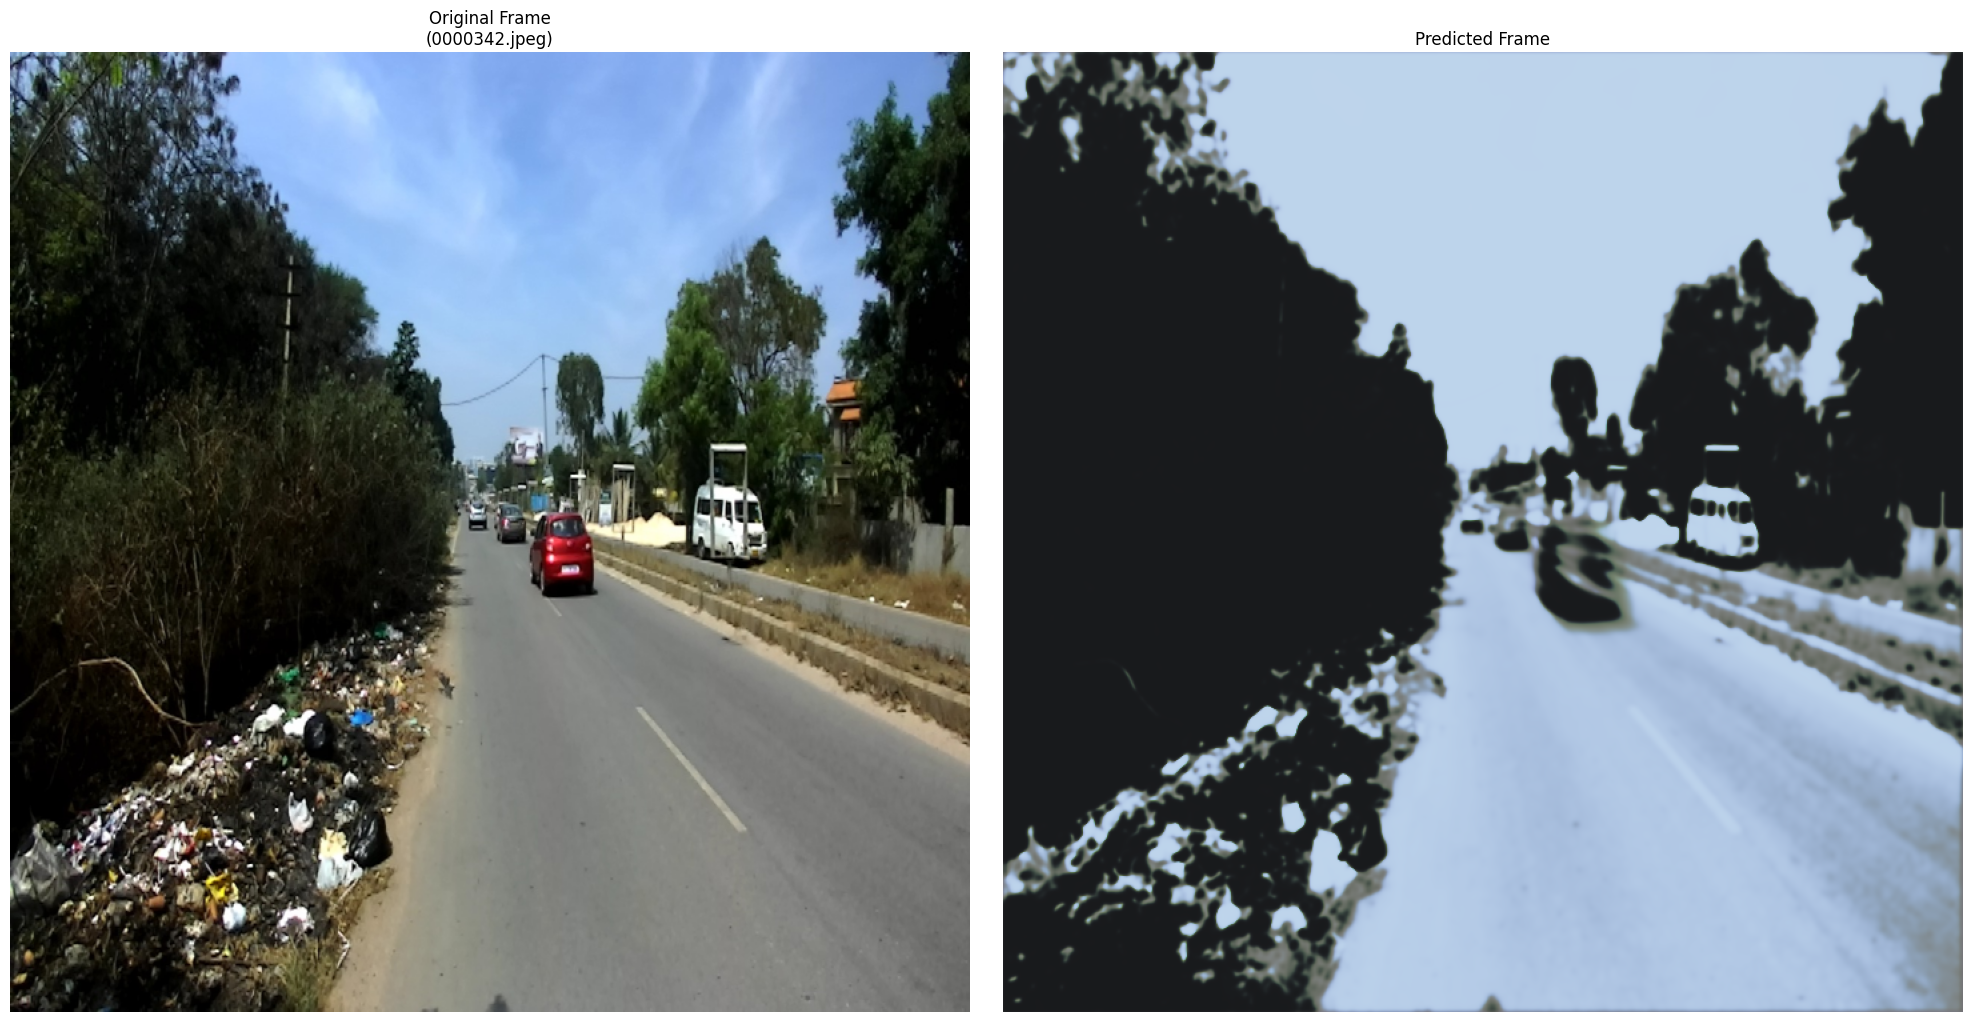

MSE: 0.029060
PSNR: 15.37 dB


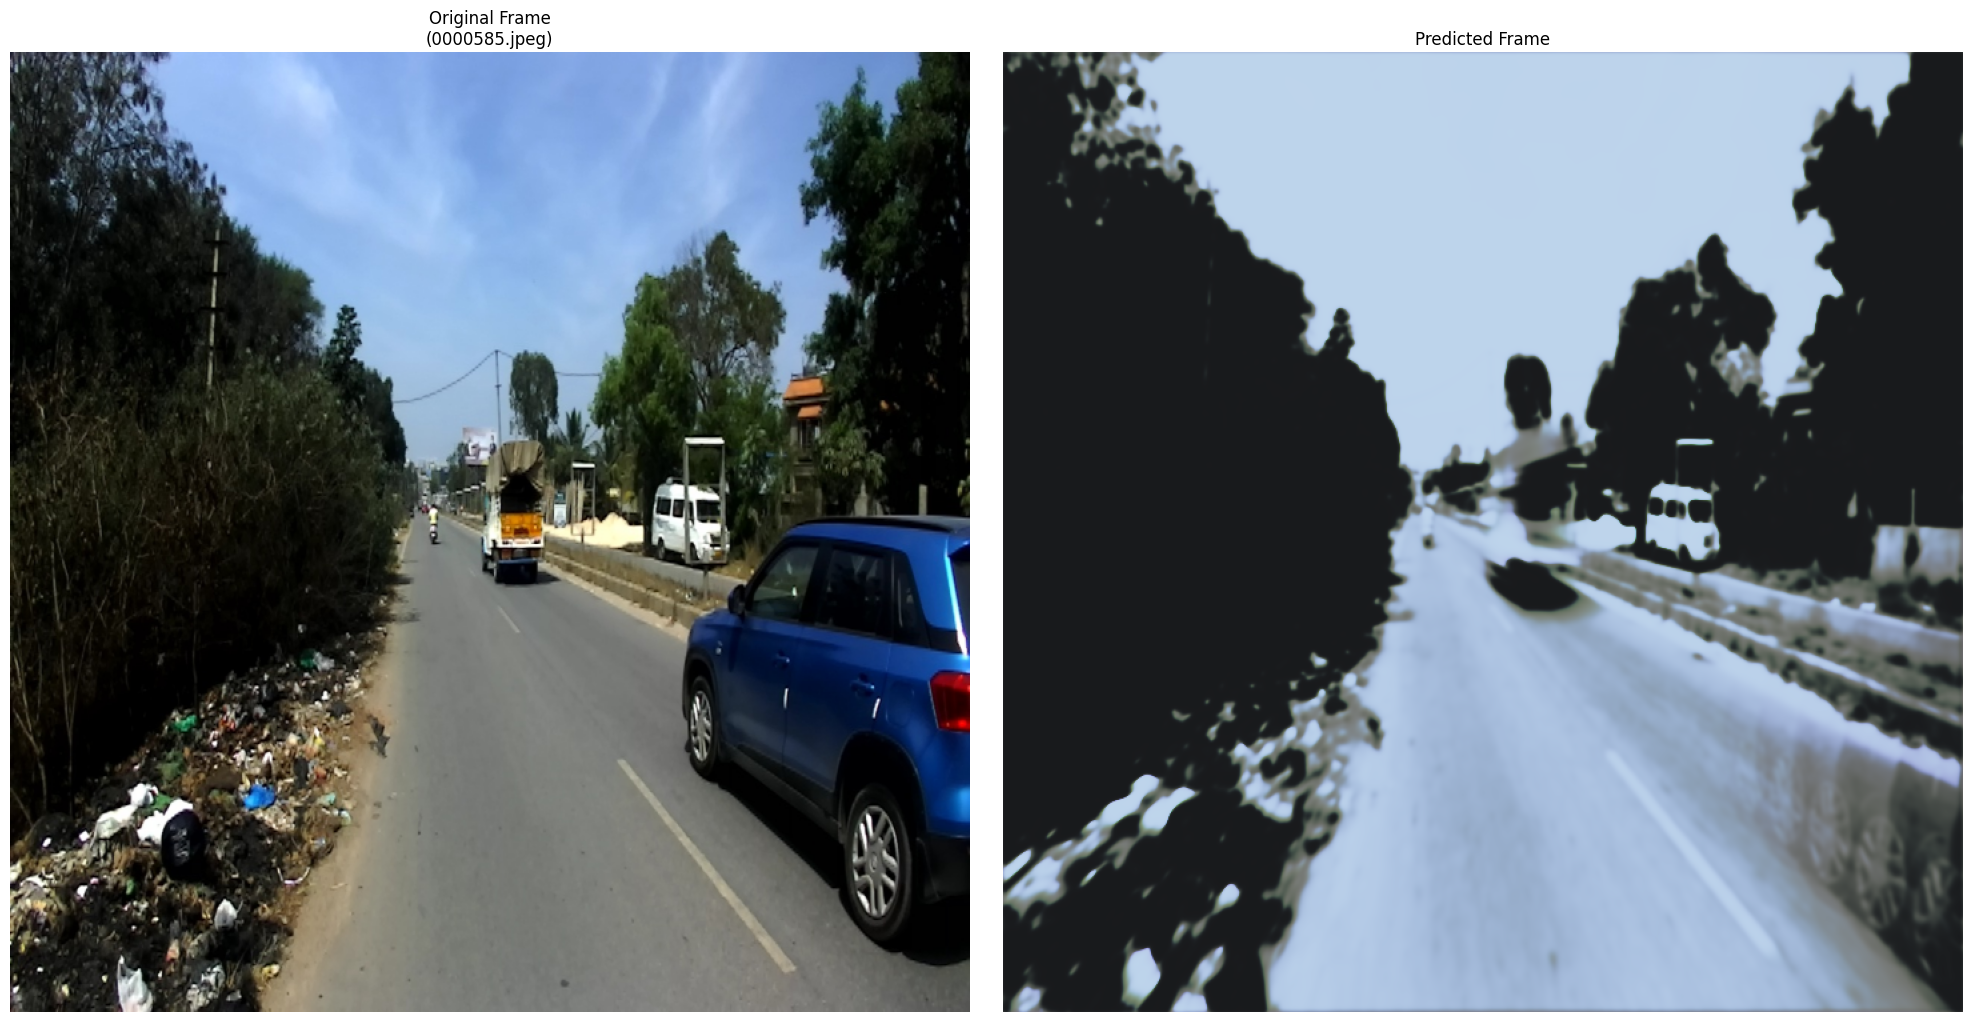

MSE: 0.046491
PSNR: 13.33 dB


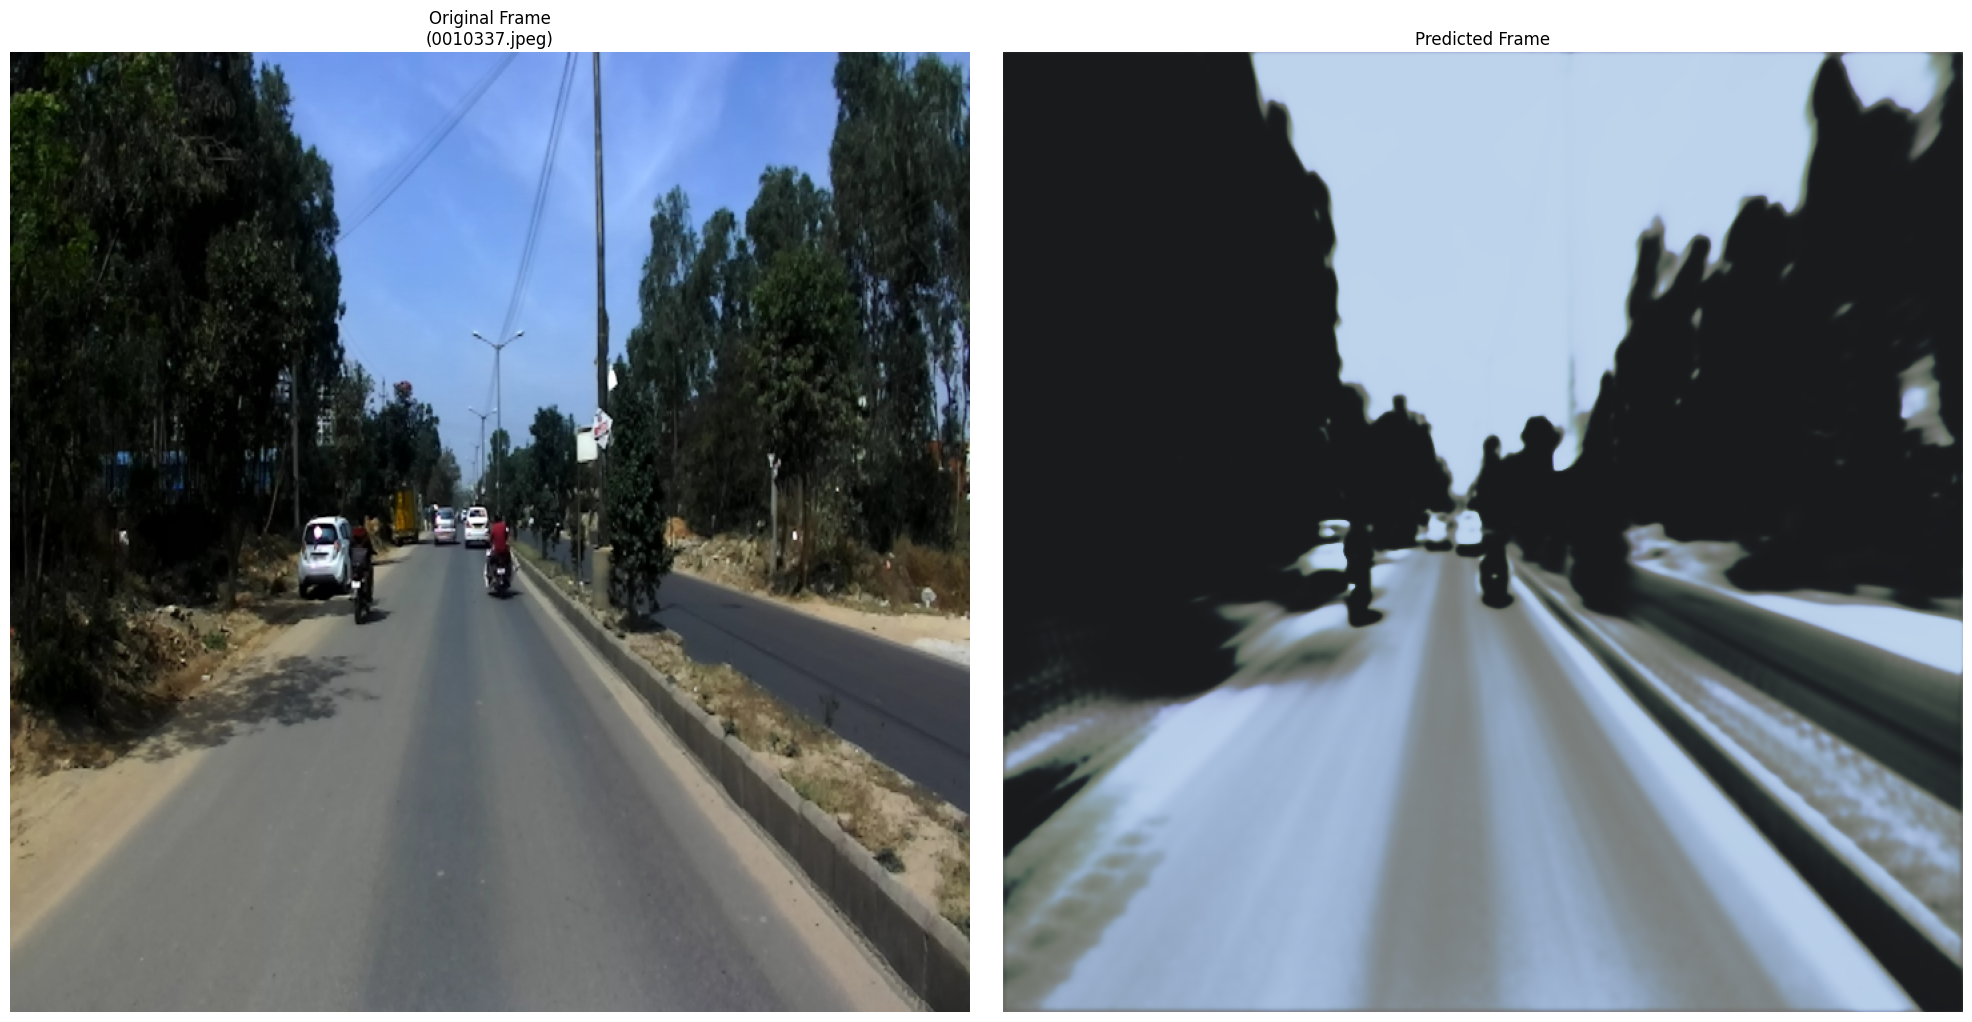

MSE: 0.036105
PSNR: 14.42 dB


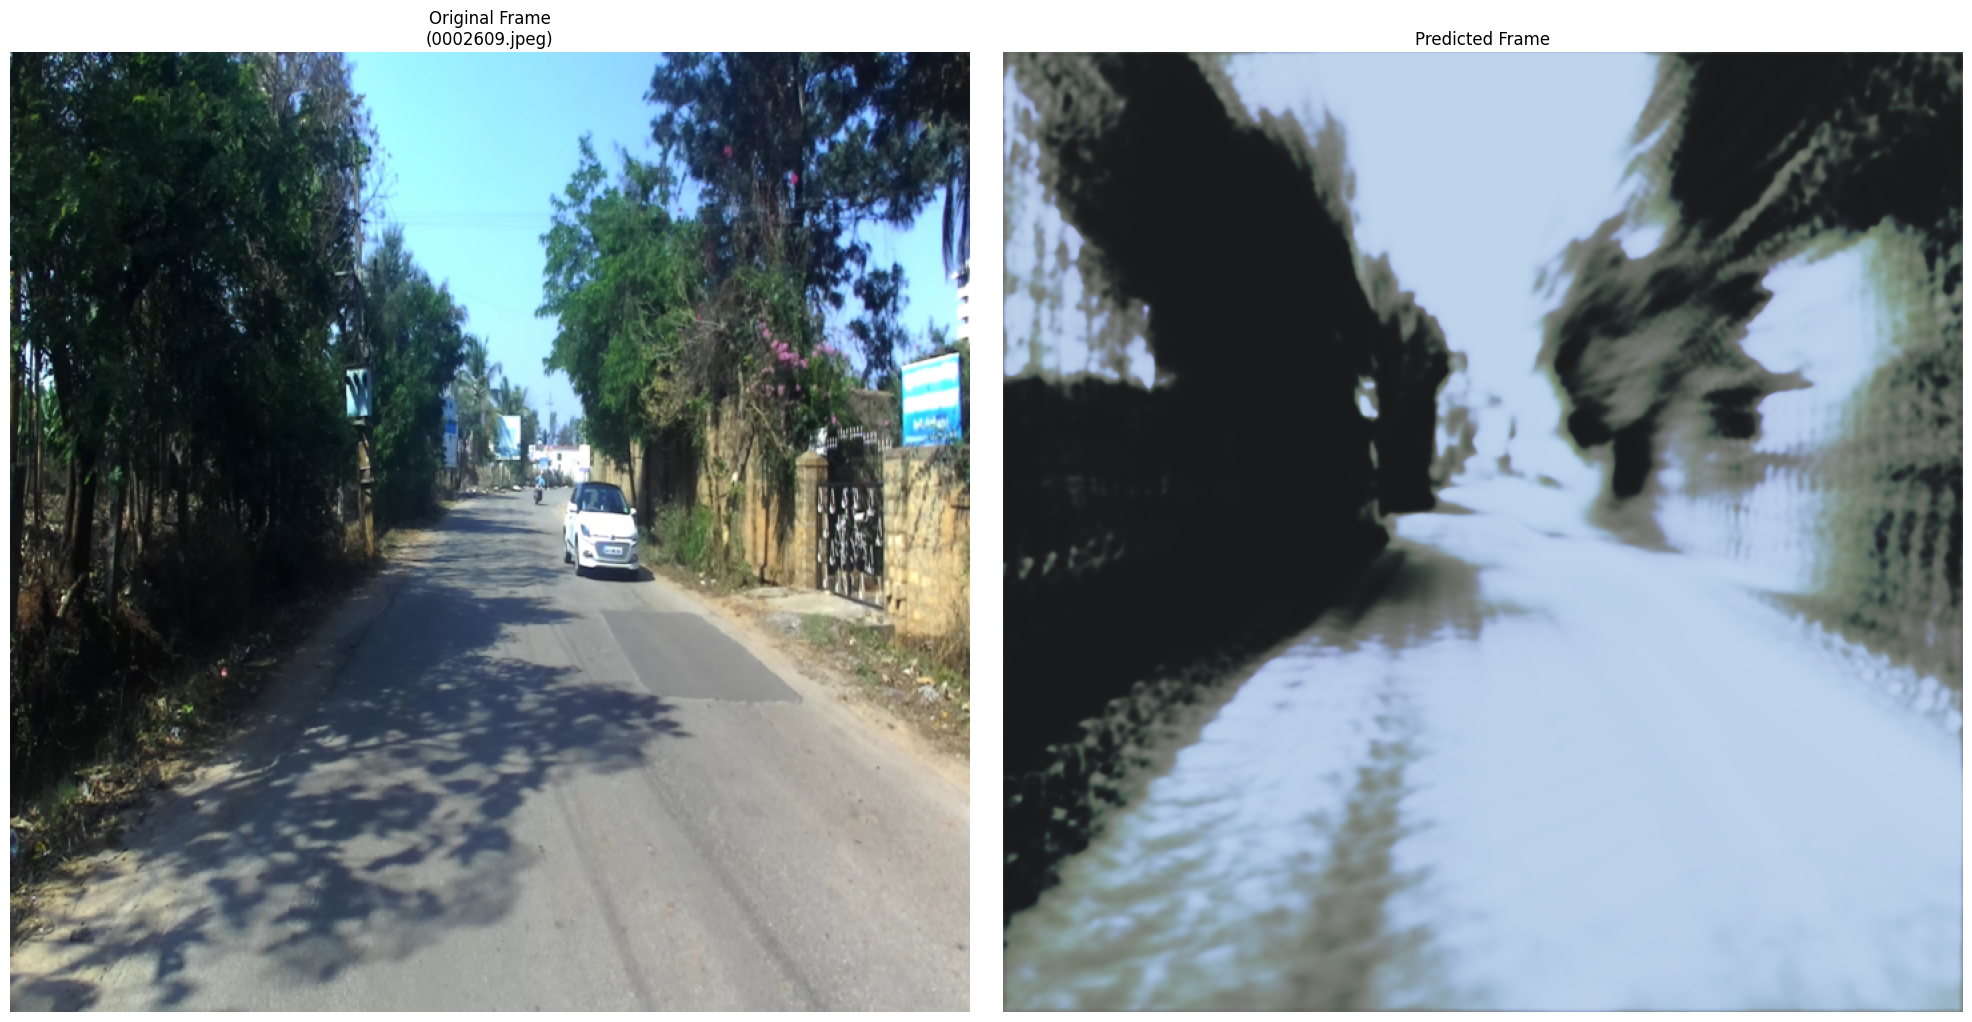

MSE: 0.072718
PSNR: 11.38 dB


In [35]:
import matplotlib.pyplot as plt
class NextFramePredictor(nn.Module):
    def __init__(self, input_channels=3, hidden_dims=[64, 32, 32], kernel_size=(3, 3)):
        super(NextFramePredictor, self).__init__()
        
        self.convlstm = ConvLSTM(
            input_dim=input_channels,
            hidden_dim=hidden_dims,
            kernel_size=kernel_size,
            num_layers=len(hidden_dims),
            batch_first=True,
            return_all_layers=False
        )
        
        # Output projection layer
        self.conv_output = nn.Conv2d(hidden_dims[-1], input_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # x shape should be: (batch, channels, time, height, width)
        # Need to reshape to: (batch, time, channels, height, width)
        x = x.permute(0, 2, 1, 3, 4)
        
        output_list, _ = self.convlstm(x)
        last_layer_output = output_list[0]  # Get output from last LSTM layer
        
        # Take the last frame prediction and project to output channels
        last_frame = last_layer_output[:, -1]  # Shape: (batch, hidden_dim, height, width)
        output = self.conv_output(last_frame)
        return self.sigmoid(output)
def load_frames(folder_path, seq_length=10):
    """Load sequence of frames from a folder"""
    frame_files = sorted(glob(os.path.join(folder_path, "*.jpeg")))
    
    if len(frame_files) < seq_length + 1:
        raise ValueError(f"Folder {folder_path} has insufficient frames")
    
    transform = transforms.Compose([
        transforms.Resize((720, 720)),
        transforms.ToTensor(),
    ])
    
    # Load input sequence
    input_frames = []
    for i in range(seq_length):
        img = Image.open(frame_files[i]).convert('RGB')
        img = transform(img)
        input_frames.append(img)
    
    # Load target frame (next frame after sequence)
    target_frame = Image.open(frame_files[seq_length]).convert('RGB')
    target_frame = transform(target_frame)
    
    # Stack frames and reshape for ConvLSTM
    input_sequence = torch.stack(input_frames)  # [T, C, H, W]
    input_sequence = input_sequence.permute(1, 0, 2, 3)  # [C, T, H, W]
    
    return input_sequence, target_frame, frame_files[seq_length]

def predict_and_visualize(model, folder_path, device="cuda"):
    """Predict next frame and visualize results"""
    model.eval()
    
    # Load frames
    input_sequence, target_frame, target_frame_path = load_frames(folder_path)
    
    # Add batch dimension and move to device
    input_sequence = input_sequence.unsqueeze(0).to(device)  # [1, C, T, H, W]
    
    # Predict
    with torch.no_grad():
        predicted_frame = model(input_sequence)
    
    # Move tensors to CPU and convert to numpy arrays
    target_frame = target_frame.cpu().numpy()
    predicted_frame = predicted_frame.cpu().numpy()[0]  # Remove batch dimension
    
    # Transpose from [C, H, W] to [H, W, C]
    target_frame = target_frame.transpose(1, 2, 0)
    predicted_frame = predicted_frame.transpose(1, 2, 0)
    
    # Clip values to [0, 1] range
    predicted_frame = np.clip(predicted_frame, 0, 1)
    
    # Create figure
    plt.figure(figsize=(20, 10))
    
    # Plot original frame
    plt.subplot(1, 2, 1)
    plt.imshow(target_frame)
    plt.title(f'Original Frame\n({os.path.basename(target_frame_path)})')
    plt.axis('off')
    
    # Plot predicted frame
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_frame)
    plt.title('Predicted Frame')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and display metrics
    mse = ((target_frame - predicted_frame) ** 2).mean()
    psnr = 20 * np.log10(1.0 / np.sqrt(mse))
    print(f'MSE: {mse:.6f}')
    print(f'PSNR: {psnr:.2f} dB')
    
    return target_frame, predicted_frame

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Initialize model
    model = NextFramePredictor(
        input_channels=3,
        hidden_dims=[64, 32, 32],
        kernel_size=(3, 3)
    ).to(device)
    
    # Load trained weights
    try:
        model.load_state_dict(torch.load('/kaggle/working/best_convlstm_model.pth', map_location=device))
        print("Model loaded successfully")
    except:
        raise Exception("Could not find trained model weights (best_convlstm_model.pth)")
    
    # Example usage
    folder_path1 = "/kaggle/input/kidding-data/Demo_testing/000290_leftImg8bit"
    folder_path2="/kaggle/input/kidding-data/Demo_testing/000590_leftImg8bit"
    folder_path3="/kaggle/input/kidding-data/Demo_testing/010342_leftImg8bit"
    folder_path4="/kaggle/input/kidding-data/Demo_testing/254869_leftImg8bit"
    
    folder_paths=[folder_path1,folder_path2,folder_path3,folder_path4]
    for path in folder_paths:
        target, prediction = predict_and_visualize(model, path, device)

if __name__ == "__main__":
    main()
